# **Generative Models (GANs)**

## Table of Contents
1. **Introduction to GANs**
   - What are GANs?
   - Why Use GANs?
   - Applications of GANs
2. **GAN Architecture**
   - Generator Network
   - Discriminator Network
   - Adversarial Training
3. **Mathematics of GANs**
   - Loss Functions
   - Minimax Game
   - Latent Space Representation
4. **Challenges in Training GANs**
   - Mode Collapse
   - Training Instability
   - Evaluation Metrics
5. **Building a GAN from Scratch**
   - Data Preparation
   - Generator and Discriminator Design
   - Training Loop
6. **Advanced GAN Variants**
   - DCGAN
   - WGAN
   - Conditional GAN
7. **Practical Tips and Best Practices**
   - Hyperparameter Tuning
   - Debugging GANs
   - Applications in Real-World Projects
8. **Conclusion**
   - Summary
   - Further Reading



## 1. Introduction to GANs

### What are GANs?
Generative Adversarial Networks (GANs) are a class of deep learning models introduced by Ian Goodfellow in 2014. They consist of two neural networks:
1. **Generator**: Creates fake data.
2. **Discriminator**: Distinguishes between real and fake data.

The two networks are trained simultaneously in a competitive manner, hence the term "adversarial."

### Why Use GANs?
1. **Data Generation**: GANs can generate realistic images, videos, audio, and more.
2. **Data Augmentation**: GANs can create synthetic data to augment small datasets.
3. **Creative Applications**: GANs are used in art, design, and entertainment.

### Applications of GANs
- **Image Synthesis**: Generating realistic images (e.g., faces, landscapes).
- **Style Transfer**: Transforming images into different artistic styles.
- **Super-Resolution**: Enhancing the resolution of low-quality images.
- **Text-to-Image Generation**: Creating images from textual descriptions.

---

## 2. GAN Architecture

### Generator Network
- **Input**: Random noise (latent vector).
- **Output**: Fake data (e.g., images).
- **Architecture**: Typically uses transposed convolutional layers to upsample the noise into data.

### Discriminator Network
- **Input**: Real or fake data.
- **Output**: Probability of the input being real.
- **Architecture**: Typically uses convolutional layers to downsample the data into a single probability.

### Adversarial Training
- The generator tries to fool the discriminator.
- The discriminator tries to correctly classify real and fake data.
- This competition drives both networks to improve.

---

## 3. Mathematics of GANs

### Loss Functions
1. **Discriminator Loss**:
   - Maximizes the probability of correctly classifying real and fake data.
   - Loss function: Binary cross-entropy.
2. **Generator Loss**:
   - Maximizes the probability of the discriminator classifying fake data as real.
   - Loss function: Binary cross-entropy.

### Minimax Game
The GAN training process can be viewed as a minimax game:
\[
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]
\]
- \(D(x)\): Discriminator's output for real data.
- \(G(z)\): Generator's output for noise \(z\).
- \(D(G(z))\): Discriminator's output for fake data.

### Latent Space Representation
- The generator takes random noise (latent vector) as input.
- The latent space is a low-dimensional representation of the data distribution.
- By manipulating the latent vector, we can control the generated output.

---

## 4. Challenges in Training GANs

### Mode Collapse
- The generator produces limited varieties of outputs.
- **Solution**: Use techniques like mini-batch discrimination or unrolled GANs.

### Training Instability
- The generator and discriminator may not converge.
- **Solution**: Use techniques like gradient penalty (WGAN-GP) or spectral normalization.

### Evaluation Metrics
- **Inception Score (IS)**: Measures the quality and diversity of generated images.
- **Fréchet Inception Distance (FID)**: Measures the similarity between real and generated data distributions.


In [1]:
## Setup
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


## Data Loading and Preprocessing


In [2]:
# Load MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5

# Reshape images to include channel dimension
train_images = np.expand_dims(train_images, axis=-1)

# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(f"Training images shape: {train_images.shape}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training images shape: (60000, 28, 28, 1)


### Explanation:
1. **Load MNIST Dataset**:
   - MNIST contains 60,000 grayscale images of handwritten digits (28x28 pixels).
2. **Normalize Pixel Values**:
   - Scale pixel values from [0, 255] to [-1, 1] for better GAN training.
3. **Reshape Images**:
   - Add a channel dimension to make the shape (28, 28, 1).
4. **Create Dataset**:
   - Use `tf.data.Dataset` to batch and shuffle the data for training.


In [3]:
## Build the Generator

def build_generator(latent_dim):
    model = models.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


In [4]:
# Create the generator
latent_dim = 100
generator = build_generator(latent_dim)
generator.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

### Explanation:
1. **Generator Architecture**:
   - Takes a latent vector (random noise) as input.
   - Uses `Dense` and `Conv2DTranspose` layers to upsample the noise into a 28x28 image.
   - Uses `BatchNormalization` and `LeakyReLU` for stability.
   - Outputs an image with pixel values in the range [-1, 1] (tanh activation).
2. **Latent Dimension**:
   - The latent vector size is 100.


In [5]:
## Build the Discriminator
def build_discriminator():
    model = models.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Create the discriminator
discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

### Explanation:
1. **Discriminator Architecture**:
   - Takes a 28x28 image as input.
   - Uses `Conv2D` layers to downsample the image.
   - Uses `LeakyReLU` and `Dropout` for stability.
   - Outputs a single value (real or fake).


In [6]:
## Define Loss Functions and Optimizers

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


### Explanation:
1. **Discriminator Loss**:
   - Maximizes the probability of correctly classifying real and fake data.
2. **Generator Loss**:
   - Maximizes the probability of the discriminator classifying fake data as real.
3. **Optimizers**:
   - Adam optimizer with a learning rate of 1e-4.


In [7]:
## Training Loop

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


### Explanation:
1. **Train Step**:
   - Generates fake images from random noise.
   - Computes discriminator predictions for real and fake images.
   - Calculates generator and discriminator losses.
   - Updates model weights using gradient descent.


Epoch 10, Generator Loss: 1.1011288166046143, Discriminator Loss: 0.9349616169929504


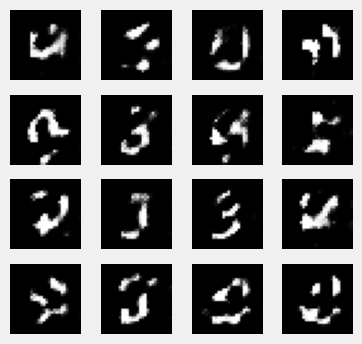

Epoch 20, Generator Loss: 1.0592217445373535, Discriminator Loss: 1.1536262035369873


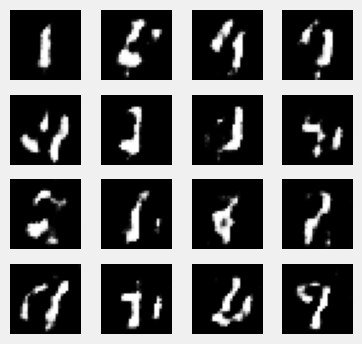

Epoch 30, Generator Loss: 0.8919717669487, Discriminator Loss: 1.3845241069793701


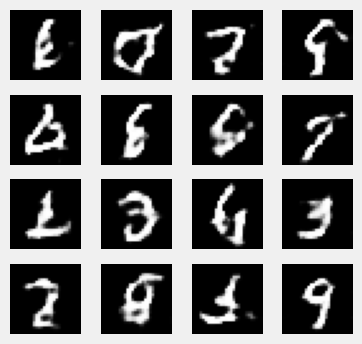

Epoch 40, Generator Loss: 0.9457326531410217, Discriminator Loss: 1.2768627405166626


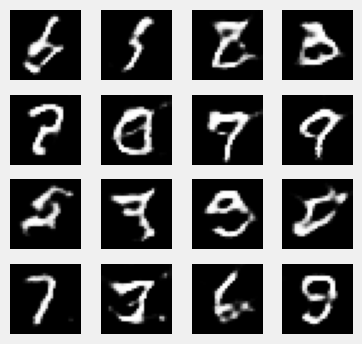

Epoch 50, Generator Loss: 1.0144037008285522, Discriminator Loss: 1.0967912673950195


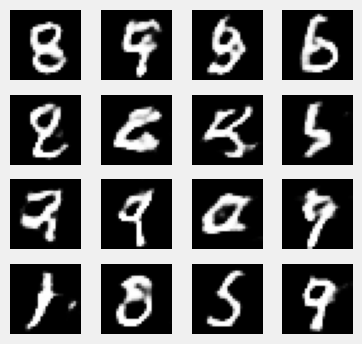

In [8]:
## Training the GAN
EPOCHS = 50
for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    # Print losses
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")

    # Generate and save images
    if (epoch + 1) % 10 == 0:
        noise = tf.random.normal([16, latent_dim])
        generated_images = generator(noise, training=False)
        plt.figure(figsize=(4, 4))
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.show()


### Explanation:
1. **Training Loop**:
   - Trains the GAN for 50 epochs.
   - Prints generator and discriminator losses every 10 epochs.
   - Generates and displays sample images every 10 epochs.

## Evaluation

### Generated Images

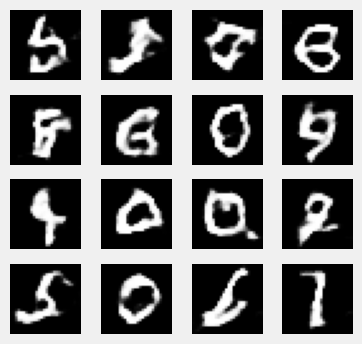

In [9]:
# Generate final images
noise = tf.random.normal([16, latent_dim])
generated_images = generator(noise, training=False)

plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()


### Explanation:
1. **Generate Images**:
   - Use the trained generator to create new images from random noise.
   - Display the generated images.


## 6. Advanced GAN Variants

### DCGAN (Deep Convolutional GAN)
- Uses convolutional layers in both generator and discriminator.
- Improves stability and quality of generated images.

### WGAN (Wasserstein GAN)
- Uses Wasserstein distance as the loss function.
- Improves training stability and avoids mode collapse.

### Conditional GAN
- Adds conditional information (e.g., class labels) to the generator and discriminator.
- Enables controlled generation of specific classes.

---

## 7. Practical Tips and Best Practices

### Hyperparameter Tuning
- **Learning Rate**: Start with 1e-4 for both generator and discriminator.
- **Batch Size**: Use larger batch sizes (e.g., 256) for stability.
- **Optimizer**: Use Adam optimizer with beta1=0.5 and beta2=0.999.

### Debugging GANs
- **Monitor Losses**: Ensure generator and discriminator losses are balanced.
- **Visualize Outputs**: Regularly check generated images for quality and diversity.

### Applications in Real-World Projects
- **Image Synthesis**: Generate realistic images for training computer vision models.
- **Data Augmentation**: Create synthetic data to improve model performance.
- **Art and Design**: Use GANs for creative applications like style transfer.

---

## 8. Conclusion

### Summary
- GANs are powerful models for generating realistic data.
- Training GANs is challenging but can be improved with advanced techniques.
- GANs have wide-ranging applications in data generation, augmentation, and creative fields.

### Further Reading
- [Original GAN Paper](https://arxiv.org/abs/1406.2661)
- [DCGAN Paper](https://arxiv.org/abs/1511.06434)
- [WGAN Paper](https://arxiv.org/abs/1701.07875)

